In [1]:
from __future__ import print_function
try:
    import pyaudio
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    print("Something didn't import")

In [2]:
%matplotlib inline  

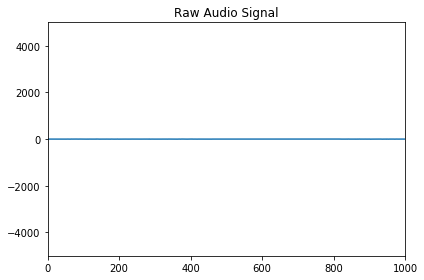

In [3]:
i=0
f,ax = plt.subplots(1)

# Prepare the Plotting Environment with random starting values
x = np.arange(10000)
y = np.random.randn(10000)

# Plot 0 is for raw audio data
li, = ax.plot(x, y)
ax.set_xlim(0,1000)
ax.set_ylim(-5000,5000)
ax.set_title("Raw Audio Signal")
# Plot 1 is for the FFT of the audio
# Show the plot, but without blocking updates
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.pause(0.01)

In [4]:
FORMAT = pyaudio.paInt16 # We use 16 bit format per sample
CHANNELS = 1
RATE = 44100
CHUNK = 1024 # 1024 bytes of data read from the buffer
RECORD_SECONDS = 0.1
WAVE_OUTPUT_FILENAME = "file.wav"

audio = pyaudio.PyAudio()

# Claim the microphone
stream = audio.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE, 
                    input=True)#,
                    #frames_per_buffer=CHUNK)

global keep_going
keep_going = True

In [5]:
def plot_data(in_data):
    # get and convert the data to float
    audio_data = np.fromstring(in_data, np.int16)
    # Force the new data into the plot, but without redrawing axes.
    li.set_xdata(np.arange(len(audio_data)))
    li.set_ydata(audio_data)
    
    # Show the updated plot, but without blocking
    plt.pause(0.01)
    if keep_going:
        return True
    else: 
        return False

In [ ]:
stream.start_stream()
print("\n+---------------------------------+")
print("| Press Ctrl+C to Break Recording |")
print( "+---------------------------------+\n")
# Loop so program doesn't end while the stream is open
while keep_going:
    try:
        plot_data(stream.read(CHUNK))
    except KeyboardInterrupt:
        keep_going=False
    except:
        pass

# Close up shop 
stream.stop_stream()
stream.close()

audio.terminate()

In [6]:
stream.start_stream()
plot_data(stream.read(CHUNK))

/home/dvh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [ ]:
import pyaudio
import numpy as np
import matplotlib
 
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = .5
WAVE_OUTPUT_FILENAME = "output.wav"
 
p = pyaudio.PyAudio()
'''
print("Input Device Info")
print(p.get_default_input_device_info())
print("Output Device Info")
print(p.get_default_output_device_info())
 
for i in range(p.get_host_api_count()):
    print(p.get_host_api_info_by_index(i))
'''
for index in range(p.get_device_count()):
    print(p.get_device_info_by_index(index))
 
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                input_device_index=0)
 
print("* recording")
 
frames = []
 
 
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
 
 
print("* done recording")
 
stream.stop_stream()
stream.close()
p.terminate()
 
time = []
 
 
audio = np.fromstring(b''.join(frames),dtype=np.int16)
 
t = np.linspace(0,RECORD_SECONDS,num=audio.size)
import matplotlib.pyplot as plt
plt.plot(t,audio)
plt.show()

In [ ]:
import pyaudio
import threading
import atexit
import numpy as np

class MicrophoneRecorder(object):
    def __init__(self, rate=4000, chunksize=1024):
        self.rate = rate
        self.chunksize = chunksize
        self.p = pyaudio.PyAudio()
        self.stream = self.p.open(format=pyaudio.paInt16,
                                  channels=1,
                                  rate=self.rate,
                                  input=True,
                                  frames_per_buffer=self.chunksize,
                                  stream_callback=self.new_frame)
        self.lock = threading.Lock()
        self.stop = False
        self.frames = []
        atexit.register(self.close)

    def new_frame(self, data, frame_count, time_info, status):
        data = np.fromstring(data, 'int16')
        with self.lock:
            self.frames.append(data)
            if self.stop:
                return None, pyaudio.paComplete
        return None, pyaudio.paContinue
    
    def get_frames(self):
        with self.lock:
            frames = self.frames
            self.frames = []
            return frames
    
    def start(self):
        self.stream.start_stream()

    def close(self):
        with self.lock:
            self.stop = True
        self.stream.close()
        self.p.terminate()

In [ ]:
from matplotlib.backends.backend_qt4agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt4agg import NavigationToolbar2QT as NavigationToolbar
import matplotlib.pyplot as plt

class MplFigure(object):
    def __init__(self, parent):
        self.figure = plt.figure(facecolor='white')
        self.canvas = FigureCanvas(self.figure)
        self.toolbar = NavigationToolbar(self.canvas, parent)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PyQt4 import QtGui, QtCore

class LiveFFTWidget(QtGui.QWidget):
    def __init__(self):
        QtGui.QWidget.__init__(self)
        
        # customize the UI
        self.initUI()
        
        # init class data
        self.initData()       
        
        # connect slots
        self.connectSlots()
        
        # init MPL widget
        self.initMplWidget()
        
    def initUI(self):

        hbox_gain = QtGui.QHBoxLayout()
        autoGain = QtGui.QLabel('Auto gain for frequency spectrum')
        autoGainCheckBox = QtGui.QCheckBox(checked=True)
        hbox_gain.addWidget(autoGain)
        hbox_gain.addWidget(autoGainCheckBox)
        
        # reference to checkbox
        self.autoGainCheckBox = autoGainCheckBox
        
        hbox_fixedGain = QtGui.QHBoxLayout()
        fixedGain = QtGui.QLabel('Manual gain level for frequency spectrum')
        fixedGainSlider = QtGui.QSlider(QtCore.Qt.Horizontal)
        hbox_fixedGain.addWidget(fixedGain)
        hbox_fixedGain.addWidget(fixedGainSlider)

        self.fixedGainSlider = fixedGainSlider

        vbox = QtGui.QVBoxLayout()

        vbox.addLayout(hbox_gain)
        vbox.addLayout(hbox_fixedGain)

        # mpl figure
        self.main_figure = MplFigure(self)
        vbox.addWidget(self.main_figure.toolbar)
        vbox.addWidget(self.main_figure.canvas)
        
        self.setLayout(vbox) 
        
        self.setGeometry(300, 300, 350, 300)
        self.setWindowTitle('LiveFFT')    
        self.show()
        # timer for callbacks, taken from:
        # http://ralsina.me/weblog/posts/BB974.html
        timer = QtCore.QTimer()
        timer.timeout.connect(self.handleNewData)
        timer.start(100)
        # keep reference to timer        
        self.timer = timer
        
     
    def initData(self):
        mic = MicrophoneRecorder()
        mic.start()  

        # keeps reference to mic        
        self.mic = mic
        
        # computes the parameters that will be used during plotting
        self.freq_vect = np.fft.rfftfreq(mic.chunksize, 
                                         1./mic.rate)
        self.time_vect = np.arange(mic.chunksize, dtype=np.float32) / mic.rate * 1000
                
    def connectSlots(self):
        pass
    
    def initMplWidget(self):
        """creates initial matplotlib plots in the main window and keeps 
        references for further use"""
        # top plot
        self.ax_top = self.main_figure.figure.add_subplot(211)
        self.ax_top.set_ylim(-32768, 32768)
        self.ax_top.set_xlim(0, self.time_vect.max())
        self.ax_top.set_xlabel(u'time (ms)', fontsize=6)

        # bottom plot
        self.ax_bottom = self.main_figure.figure.add_subplot(212)
        self.ax_bottom.set_ylim(0, 1)
        self.ax_bottom.set_xlim(0, self.freq_vect.max())
        self.ax_bottom.set_xlabel(u'frequency (Hz)', fontsize=6)
        # line objects        
        self.line_top, = self.ax_top.plot(self.time_vect, 
                                         np.ones_like(self.time_vect))
        
        self.line_bottom, = self.ax_bottom.plot(self.freq_vect,
                                               np.ones_like(self.freq_vect))
                                               

                                               
    def handleNewData(self):
        """ handles the asynchroneously collected sound chunks """        
        # gets the latest frames        
        frames = self.mic.get_frames()
        
        if len(frames) > 0:
            # keeps only the last frame
            current_frame = frames[-1]
            # plots the time signal
            self.line_top.set_data(self.time_vect, current_frame)
            # computes and plots the fft signal            
            fft_frame = np.fft.rfft(current_frame)
            if self.autoGainCheckBox.checkState() == QtCore.Qt.Checked:
                fft_frame /= np.abs(fft_frame).max()
            else:
                fft_frame *= (1 + self.fixedGainSlider.value()) / 5000000.
                #print(np.abs(fft_frame).max())
            self.line_bottom.set_data(self.freq_vect, np.abs(fft_frame))            
            
            # refreshes the plots
            self.main_figure.canvas.draw()